In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.stats import f_oneway, kruskal, ttest_1samp, ttest_rel, wilcoxon


# Data cleaning & merging

The subject_list is a list which includes all the subject names and their trials e.g. Eric01, Amy02.

In [3]:
len(subject_list)

27

In [4]:
def merge_df(subjects):
    df_list = []
    
    for name in subjects:
        #print(name)
        # read useful columns from csv
        df_eeg = pd.read_csv('eeg/eeg_{}.csv'.format(name), usecols = ['time_norm', 'attention'])
        
        df_exp = pd.read_csv('exp/{}_exp.csv'.format(name), usecols = ['wordItem', 'key_res.corr', 
                                                             'key_res.rt', 'text_started_norm',
                                                             'letter_started_norm', 'trial_end_norm'])
        
        # exclude the two trials with vowels
        df_exp = df_exp.drop(df_exp[(df_exp['wordItem'] == 'THEJNP') | (df_exp['wordItem'] == 'NLTUF')].index)
        
        # drop na rows (break between blocks)
        df_exp = df_exp.dropna().reset_index(drop = True)
        
        # extract the corresponding mean attention for each trail from eeg data
        # based on the time stamp from both data
        df_exp['mean_attention'] = df_exp.apply(
            lambda x: df_eeg[(df_eeg['time_norm'] <= x.letter_started_norm) & 
                             (df_eeg['time_norm'] >= x.text_started_norm)]['attention'].mean(), 
            axis = 1)
        
        # normalize the attention to avoid individual differences
        scalar = MinMaxScaler()
        scalar.fit(np.array(df_exp['mean_attention']).reshape(-1,1))
        df_exp['attention_norm'] = scalar.transform(np.array(df_exp['mean_attention']).reshape(-1,1)) * 100
        
        # get the meomory set length
        df_exp['set_length'] = df_exp['wordItem'].apply(len)
        # divide the dataset into low memory load vs high memory load
        df_exp['2_groups'] = df_exp['set_length'].apply(lambda x: 'low' if x <= 3 else 'high')
        # divide the dataset into low vs medium vs high memory load
        df_exp['3_groups'] = df_exp['set_length'].apply(lambda x: 'low' if x <= 3 else ('medium' if x <= 4 else 'high'))
        
        df_list.append(df_exp)
        
    return df_list       

In [5]:
processed_df = merge_df(subject_list)

# Two-sample paired t-test between low vs high across subjects

In [6]:
mean_low_list = []
mean_high_list = []
mean_diff_list = []

for subject in processed_df:
    mean_both = subject[subject['key_res.corr'] == 1].groupby('2_groups')['attention_norm'].mean()
    mean_low_list.append(mean_both['low'])
    mean_high_list.append(mean_both['high'])
    mean_diff_list.append(mean_both.diff()[-1])


In [7]:
non_para = wilcoxon(mean_diff_list, alternative = 'less')
non_para.pvalue

0.017249098178553024

In [8]:
para = ttest_rel(mean_low_list, mean_high_list, alternative = 'less')
para.pvalue

0.016120002307280588

In [9]:
two_sample = pd.DataFrame({'p-value': [para.pvalue, non_para.pvalue]}, index = ['Two-sample Paired T-test', 'Wilcoxon signed-rank test'])
two_sample

,p-value
Two-sample Paired T-test,0.016120
Wilcoxon signed-rank test,0.017249


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

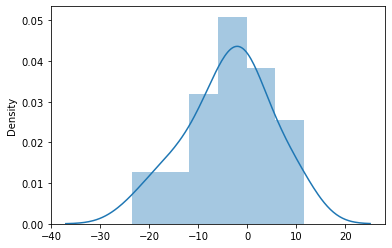

In [10]:
sns.distplot(x = mean_diff_list)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

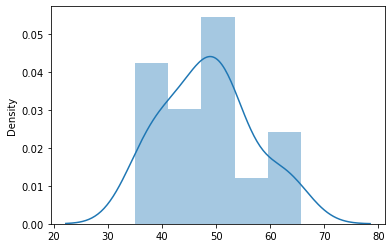

In [11]:
sns.distplot(x = mean_low_list)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

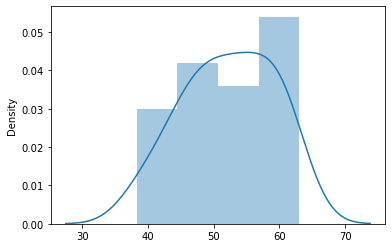

In [12]:
sns.distplot(x = mean_high_list)

# All data combined

In [13]:
df_final = pd.concat(processed_df)
df_final

,wordItem,key_res.corr,key_res.rt,text_started_norm,letter_started_norm,trial_end_norm,mean_attention,attention_norm,set_length,2_groups,3_groups
0,N,1.0,9.981157,0.000000,2.497806,12.497524,37.676806,10.875050,1,low,low
1,SDFGH,1.0,1.304701,12.999884,15.514584,16.847637,36.746570,8.564989,5,high,high
2,QLKBD,1.0,1.041115,17.348536,19.847771,20.914686,73.407407,99.605128,5,high,high
3,MP,1.0,0.886369,25.214011,27.714839,28.631381,54.646417,53.015817,2,low,low
4,X,1.0,1.002368,36.633146,39.147779,40.181515,39.398739,15.151140,1,low,low
...,...,...,...,...,...,...,...,...,...,...,...
23,LSRT,1.0,0.705103,102.630426,105.130753,105.864100,83.101562,72.694767,4,high,medium
24,V,1.0,0.619691,106.364302,108.863961,109.513814,97.451356,100.000000,1,low,low
25,MRWD,1.0,0.915107,110.014398,112.514440,113.447144,44.898084,0.000000,4,high,medium
26,DMJ,1.0,1.034012,113.947759,116.447417,117.514428,69.252366,46.342085,3,low,low


Divided into two tables with correct trials and incorrect trials.

In [14]:
df_correct = df_final[df_final['key_res.corr'] == 1]
df_incorrect = df_final[df_final['key_res.corr'] == 0]

In [15]:
df_final['set_length'].value_counts()

1    158
3    134
4    133
6    108
5    106
2    105
Name: set_length, dtype: int64

In [16]:
df_correct['set_length'].value_counts()

1    155
3    134
4    131
2    102
5    100
6     93
Name: set_length, dtype: int64

Trials with set length 6 seems has more incorrect trials compares to other lengths.

In [17]:
df_incorrect['set_length'].value_counts()

6    15
5     6
1     3
2     3
4     2
Name: set_length, dtype: int64

<AxesSubplot:xlabel='set_length', ylabel='count'>

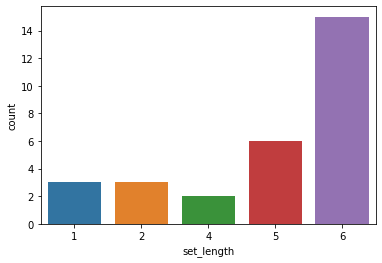

In [18]:
sns.countplot(x = "set_length", data = df_incorrect)

We will focus on correct trials for the following analysis.

## Attention

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


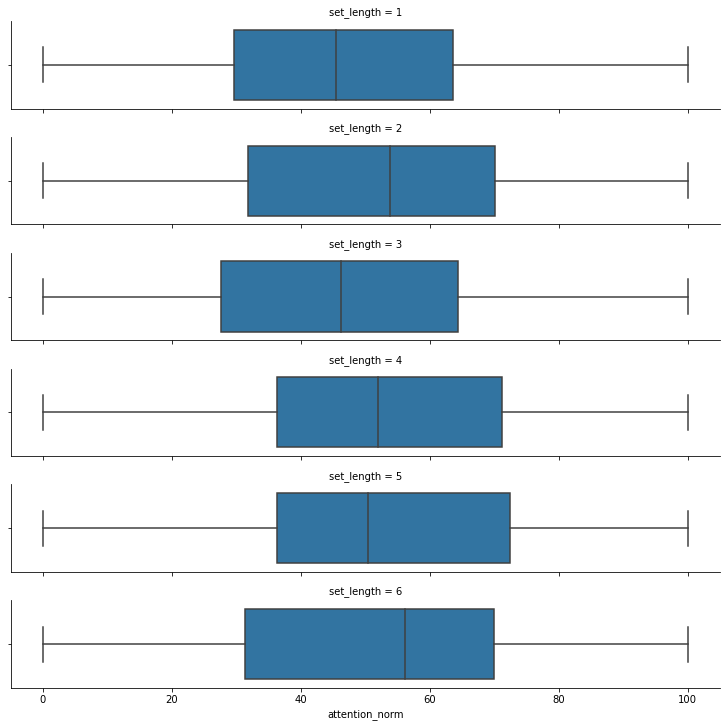

In [19]:
a_box = sns.FacetGrid(df_correct, row="set_length", row_order = range(1, 7),
                  height=1.7, aspect=6,)
a_box.map(sns.boxplot, "attention_norm")

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


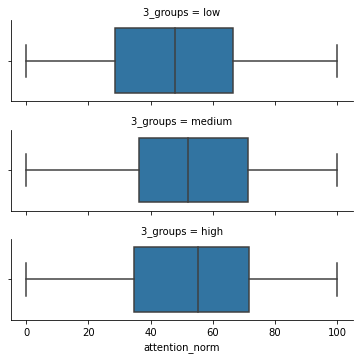

In [20]:
a_box3 = sns.FacetGrid(df_correct, row="3_groups", row_order = ['low', 'medium', 'high'],
                  height=1.7, aspect=3,)
a_box3.map(sns.boxplot, "attention_norm")

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


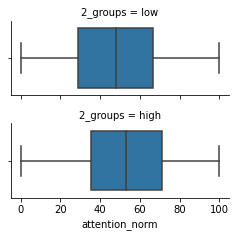

In [21]:
a_box2 = sns.FacetGrid(df_correct, row="2_groups", row_order = ['low', 'high'],
                  height=1.7, aspect=2,)
a_box2.map(sns.boxplot, "attention_norm")

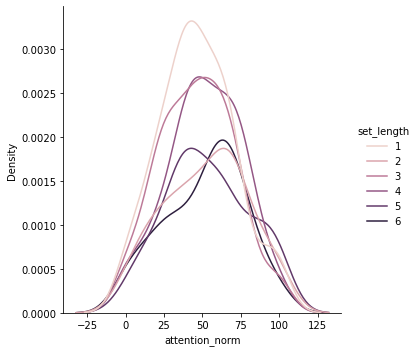

In [22]:
sns.displot(df_correct, x="attention_norm", hue="set_length", kind="kde")

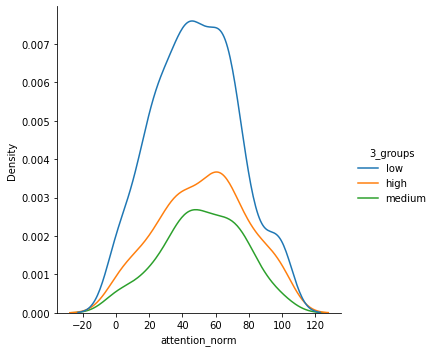

In [23]:
sns.displot(df_correct, x="attention_norm", hue="3_groups", kind="kde")

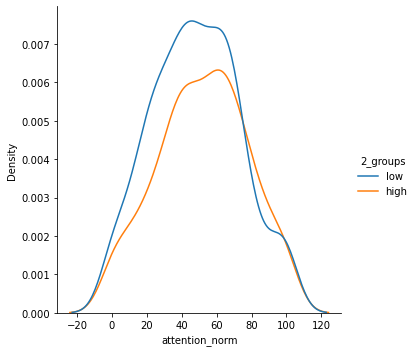

In [24]:
sns.displot(df_correct, x="attention_norm", hue="2_groups", kind="kde")

## Response time

<AxesSubplot:xlabel='key_res.rt'>

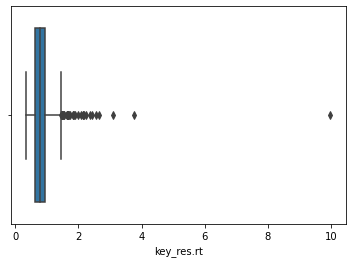

In [25]:
sns.boxplot(x = df_correct['key_res.rt'])

There are outliers that affects the whole plot. A response time with larger than 2 seconds is not common and also way too long. We'll just exclude them with the following analysis.

In [26]:
df_correct_2 = df_correct[df_correct['key_res.rt'] <= 2]
df_correct_2

,wordItem,key_res.corr,key_res.rt,text_started_norm,letter_started_norm,trial_end_norm,mean_attention,attention_norm,set_length,2_groups,3_groups
1,SDFGH,1.0,1.304701,12.999884,15.514584,16.847637,36.746570,8.564989,5,high,high
2,QLKBD,1.0,1.041115,17.348536,19.847771,20.914686,73.407407,99.605128,5,high,high
3,MP,1.0,0.886369,25.214011,27.714839,28.631381,54.646417,53.015817,2,low,low
4,X,1.0,1.002368,36.633146,39.147779,40.181515,39.398739,15.151140,1,low,low
5,WZSKR,1.0,0.831372,44.731405,47.231306,48.081598,36.553822,8.086336,5,high,high
...,...,...,...,...,...,...,...,...,...,...,...
23,LSRT,1.0,0.705103,102.630426,105.130753,105.864100,83.101562,72.694767,4,high,medium
24,V,1.0,0.619691,106.364302,108.863961,109.513814,97.451356,100.000000,1,low,low
25,MRWD,1.0,0.915107,110.014398,112.514440,113.447144,44.898084,0.000000,4,high,medium
26,DMJ,1.0,1.034012,113.947759,116.447417,117.514428,69.252366,46.342085,3,low,low


/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


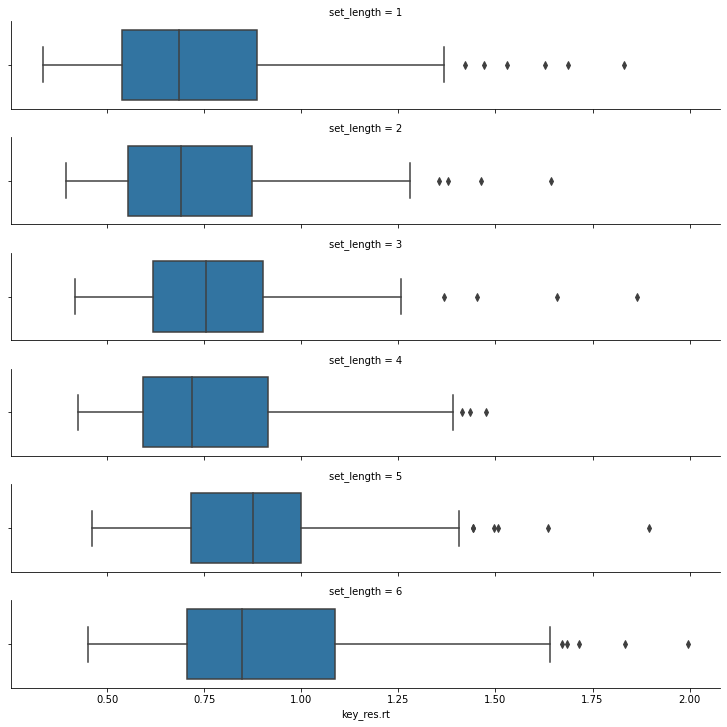

In [27]:
rt_box = sns.FacetGrid(df_correct_2, row="set_length", row_order = range(1, 7),
                  height=1.7, aspect=6,)
rt_box.map(sns.boxplot, "key_res.rt")

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


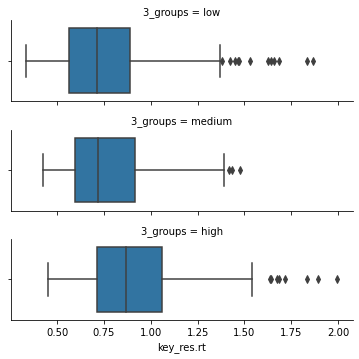

In [28]:
rt_box3 = sns.FacetGrid(df_correct_2, row="3_groups", row_order = ['low', 'medium', 'high'],
                  height=1.7, aspect=3,)
rt_box3.map(sns.boxplot, "key_res.rt")

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


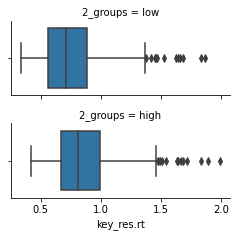

In [29]:
rt_box2 = sns.FacetGrid(df_correct_2, row="2_groups", row_order = ['low', 'high'],
                  height=1.7, aspect=2,)
rt_box2.map(sns.boxplot, "key_res.rt")

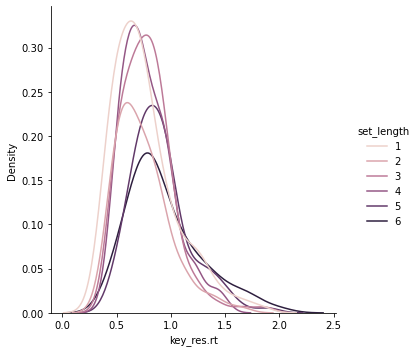

In [30]:
sns.displot(df_correct_2, x="key_res.rt", hue="set_length", kind="kde")

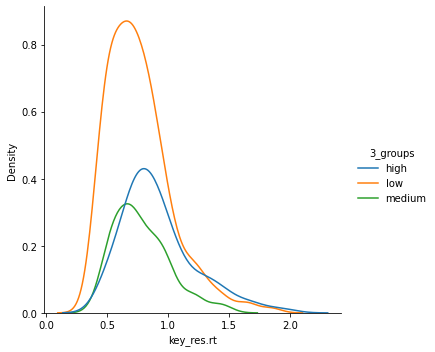

In [31]:
sns.displot(df_correct_2, x="key_res.rt", hue="3_groups", kind="kde")

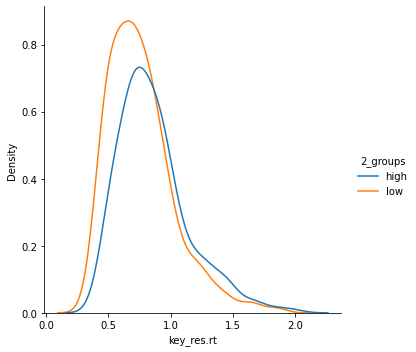

In [32]:
sns.displot(df_correct_2, x="key_res.rt", hue="2_groups", kind="kde")

# Anova
The following analysis will be done in order with 6 groups (1-6), 3 groups (low & medium & high), 2 groups (low & high).

## Attention

In [33]:
a_att_6 = f_oneway(df_correct_2['attention_norm'][df_correct_2['set_length'] == 1],
         df_correct_2['attention_norm'][df_correct_2['set_length'] == 2],
         df_correct_2['attention_norm'][df_correct_2['set_length'] == 3],
         df_correct_2['attention_norm'][df_correct_2['set_length'] == 4],
         df_correct_2['attention_norm'][df_correct_2['set_length'] == 5],
         df_correct_2['attention_norm'][df_correct_2['set_length'] == 6]
        )

In [34]:
a_att_3 = f_oneway(df_correct_2['attention_norm'][df_correct_2['set_length'] <= 2],
         df_correct_2['attention_norm'][(df_correct_2['set_length'] >= 3) & (df_correct_2['set_length'] <= 4)],
         df_correct_2['attention_norm'][df_correct_2['set_length'] >= 5]
        )

In [35]:
a_att_2 = f_oneway(df_correct_2['attention_norm'][df_correct_2['set_length'] <= 3],
         df_correct_2['attention_norm'][df_correct_2['set_length'] >= 4]
        )

## Response time

In [46]:
a_rt_6 = f_oneway(df_correct_2['key_res.rt'][df_correct_2['set_length'] == 1],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] == 2],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] == 3],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] == 4],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] == 5],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] == 6]
        )

In [47]:
a_rt_3 = f_oneway(df_correct_2['key_res.rt'][df_correct_2['set_length'] <= 2],
         df_correct_2['key_res.rt'][(df_correct_2['set_length'] >= 3) & 
                                    (df_correct_2['set_length'] <= 4)],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] >= 5]
        )

In [48]:
a_rt_2 = f_oneway(df_correct_2['key_res.rt'][df_correct_2['set_length'] <= 3],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] >= 4]
        )

# Kruskal
The following analysis will be done in order with 6 groups (1-6), 3 groups (low & medium & high), 2 groups (low & high).

## Attention

In [51]:
k_att_6 = kruskal(df_correct_2['attention_norm'][df_correct_2['set_length'] == 1],
         df_correct_2['attention_norm'][df_correct_2['set_length'] == 2],
         df_correct_2['attention_norm'][df_correct_2['set_length'] == 3],
         df_correct_2['attention_norm'][df_correct_2['set_length'] == 4],
         df_correct_2['attention_norm'][df_correct_2['set_length'] == 5],
         df_correct_2['attention_norm'][df_correct_2['set_length'] == 6]
        )

In [49]:
k_att_3 = kruskal(df_correct_2['attention_norm'][df_correct_2['set_length'] <= 2],
         df_correct_2['attention_norm'][(df_correct_2['set_length'] >= 3) & 
                                        (df_correct_2['set_length'] <= 4)],
         df_correct_2['attention_norm'][df_correct_2['set_length'] >= 5]
        )

In [50]:
k_att_2 = kruskal(df_correct_2['attention_norm'][df_correct_2['set_length'] <= 3],
         df_correct_2['attention_norm'][df_correct_2['set_length'] >= 4]
        )

## Response time

In [52]:
k_rt_6 = kruskal(df_correct_2['key_res.rt'][df_correct_2['set_length'] == 1],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] == 2],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] == 3],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] == 4],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] == 5],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] == 6]
        )

In [53]:
k_rt_3 = kruskal(df_correct_2['key_res.rt'][df_correct_2['set_length'] <= 2],
         df_correct_2['key_res.rt'][(df_correct_2['set_length'] >= 3) & 
                                    (df_correct_2['set_length'] <= 4)],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] >= 5]
        )

In [54]:
k_rt_2 = kruskal(df_correct_2['key_res.rt'][df_correct_2['set_length'] <= 3],
         df_correct_2['key_res.rt'][df_correct_2['set_length'] >= 4]
        )

# Conclustion

- Analysis on attention has over all no significant effect except for data devided into two groups (low with set_length 1-3 & high with set_length 4-6). With 2 groups, the Anova p-value for attention is 0.03741779599833731 and the Kruskal p-value for attention is 0.029390089572607983.
- However, the two_sample paired t-test & Wilcoxon signed-rank test did show significant results with p-value 0.016120002307280588 and 0.017249098178553024.
- Analysis on response time has over all significant result for all three grouping methods, for both Anova and Kruskal tests.

In [45]:
two_sample

,p-value
Two-sample Paired T-test,0.016120
Wilcoxon signed-rank test,0.017249


In [61]:
attention = pd.DataFrame({'Anova': [a_att_6.pvalue, a_att_3.pvalue, a_att_2.pvalue], 
                          'Kruskal': [k_att_6.pvalue, k_att_3.pvalue, k_att_2.pvalue]}, 
                         index = ['6 groups', '3 groups', '2 groups'])
attention

,Anova,Kruskal
6 groups,0.144911,0.120028
3 groups,0.308068,0.325128
2 groups,0.037418,0.029390


In [62]:
response_time = pd.DataFrame({'Anova': [a_rt_6.pvalue, a_rt_3.pvalue, a_rt_2.pvalue], 
                              'Kruskal': [k_rt_6.pvalue, k_rt_3.pvalue, k_rt_2.pvalue]},
                            index = ['6 groups', '3 groups', '2 groups'])
response_time

,Anova,Kruskal
6 groups,1.232807e-08,6.480790e-09
3 groups,2.244066e-10,7.206435e-11
2 groups,1.136904e-06,1.495440e-07
